In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

print(torch.cuda.get_device_name())
print(torch.__version__, torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

NVIDIA RTX A2000 8GB Laptop GPU
2.0.0+cu118 True
cuda:0


In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:

x_data = np.loadtxt('../data/env1/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env1/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env1/theta.csv', delimiter=',',encoding="utf-8-sig")
"""
x_data = np.loadtxt('../data/env2/x.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env2/y.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env2/theta.csv', delimiter=',',encoding="utf-8-sig")

x_data = np.loadtxt('../data/env1/x_extract.csv', delimiter=',',encoding="utf-8-sig")
y_data = np.loadtxt('../data/env1/y_extract.csv', delimiter=',',encoding="utf-8-sig")
theta_data = np.loadtxt('../data/env1/theta_extract.csv', delimiter=',',encoding="utf-8-sig")
"""

'\nx_data = np.loadtxt(\'../data/env2/x.csv\', delimiter=\',\',encoding="utf-8-sig")\ny_data = np.loadtxt(\'../data/env2/y.csv\', delimiter=\',\',encoding="utf-8-sig")\ntheta_data = np.loadtxt(\'../data/env2/theta.csv\', delimiter=\',\',encoding="utf-8-sig")\n\nx_data = np.loadtxt(\'../data/env1/x_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\ny_data = np.loadtxt(\'../data/env1/y_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\ntheta_data = np.loadtxt(\'../data/env1/theta_extract.csv\', delimiter=\',\',encoding="utf-8-sig")\n'

In [4]:
x_data_input = np.stack([x_data[:, 0],x_data[:, -1]], axis=1)
y_data_input = np.stack([y_data[:, 0],y_data[:, -1]], axis=1)
theta_data_input = np.stack([theta_data[:, 0],theta_data[:, -1]], axis=1)

x_data_output = x_data[:, 1:-1]
y_data_output = y_data[:, 1:-1]

In [5]:
input_data = np.concatenate([x_data_input, y_data_input, theta_data_input], axis=1)
output_data = np.concatenate([x_data_output, y_data_output], axis=1)

print(input_data)
print(output_data)

[[-1.95089677 26.85336784  2.90165733  0.51550384  0.76052138  0.2704835 ]
 [-1.39265343 28.42921012  1.67284633 -1.89030781 -1.53883245 -0.03173356]
 [-1.76492294 29.18854837  2.25704062  0.716587    0.2927443   0.83952279]
 ...
 [-1.31542913 28.42032177 -2.72933061  0.55586043 -0.37881141 -1.12815121]
 [ 3.85745585 27.59609971  0.2057426  -1.91472504 -1.21443498  0.76625774]
 [ 0.52651487 29.04215692  1.06680278  2.89433747 -1.32301624 -0.17481412]]
[[-1.68718655 -0.55750106  0.61453933 ... -1.00577329 -0.52344684
  -0.02743804]
 [-1.39265343 -1.32873657 -1.32873657 ... -2.21776662 -2.07738736
  -1.95777503]
 [-0.78487723  0.35221506  1.50500404 ... -1.27094711 -0.73473553
  -0.08622076]
 ...
 [-1.31542913  0.34409731  1.50640375 ... -0.57499886  0.45744451
   1.25732107]
 [ 3.85745585  4.43214483  5.09614909 ... -2.85605095 -2.69107545
  -2.4428802 ]
 [ 0.52651487  0.52651487  1.01701977 ...  3.53108216  3.3123551
   3.09773156]]


In [6]:
"""
#input_dataに対して最小最大スケーリングを行う
input_data_normalized = (input_data - np.min(input_data, axis=0)) / (np.max(input_data, axis=0) - np.min(input_data, axis=0))
print(input_data_normalized)
"""

'\n#input_dataに対して最小最大スケーリングを行う\ninput_data_normalized = (input_data - np.min(input_data, axis=0)) / (np.max(input_data, axis=0) - np.min(input_data, axis=0))\nprint(input_data_normalized)\n'

In [7]:
class MyDataset(Dataset):
    def __init__(self, input_data, output_data):
        super(MyDataset, self).__init__()
        self.input_data = input_data
        self.output_data = output_data

    def __getitem__(self, index):
        input = torch.tensor(self.input_data[index], dtype=torch.float32)
        output = torch.tensor(self.output_data[index], dtype=torch.float32)
        return input, output

    def __len__(self):
        return len(self.input_data)

In [8]:
train_valid_data = MyDataset(input_data, output_data)

val_size = 2000
train_data, val_data = torch.utils.data.random_split(train_valid_data, [len(train_valid_data)-val_size, val_size])

In [10]:
train_data[0]

(tensor([-1.4097, 30.4821, -1.9517,  1.7120,  1.3183, -0.6094]),
 tensor([-1.3186, -0.8960,  0.0413,  1.0920,  2.1885,  3.3123,  4.4515,  5.6056,
          6.7692,  7.9380,  9.1111, 10.2909, 11.4739, 12.6538, 13.8260, 14.9916,
         16.1591, 17.3342, 18.5080, 19.6926, 20.9027, 22.1124, 23.3094, 24.5047,
         25.7008, 26.8939, 28.0838, 29.2748, -1.5987,  0.0392,  1.0433,  1.7789,
          2.3433,  2.7910,  3.1522,  3.4484,  3.6932,  3.8964,  4.0657,  4.2071,
          4.3237,  4.4171,  4.4885,  4.5386,  4.5669,  4.5707,  4.5459,  4.4865,
          4.3816,  4.2340,  4.0470,  3.8188,  3.5445,  3.2165,  2.8215,  2.3357]))

In [33]:
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True
)

dataloader_valid = torch.utils.data.DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=True
)

In [34]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [35]:
# ハイパーパラメータの設定
input_size = input_data.shape[1]
hidden_size = 2000
output_size = output_data.shape[1]
learning_rate = 0.001
num_epochs = 100

# モデルの定義
model = MLP(input_size, hidden_size, output_size).to(device)

In [36]:
# 損失関数の定義
criterion = nn.MSELoss()

# オプティマイザの定義
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#トレーニングの開始
train_loss_list, val_loss_list = [], []

for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    
    #train_mode
    model.train()
    for i, (input_data, output_data) in enumerate(dataloader_train):
        # データをGPUに転送
        input_data, output_data = input_data.to(device), output_data.to(device)
        
        # モデルの出力を計算
        output = model(input_data.view(-1, input_size))
        
        # 損失関数の適用
        loss = criterion(output, output_data)
        
        #train_lossに結果を蓄積
        train_loss += loss.item()
        
        # 勾配を初期化して逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # lossの平均を計算
        avg_train_loss = train_loss / len(dataloader_train.dataset)  
        
    #valid_mode
    model.eval()
    with torch.no_grad():
        for input_data, output_data in dataloader_valid:
            # データをGPUに転送
            input_data, output_data = input_data.to(device), output_data.to(device)
            
            # モデルの出力を計算
            output = model(input_data.view(-1, input_size))
            
            # 損失関数の適用
            loss = criterion(output, output_data)
        
            #val_lossに結果を蓄積
            val_loss += loss.item()
    
    # lossの平均を計算      
    avg_val_loss = val_loss / len(dataloader_valid.dataset)
    
    # print log
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}'.format(epoch+1, num_epochs, i+1, loss=avg_train_loss, val_loss=avg_val_loss))
    
    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)



Epoch [1/100], Loss: 0.3518, val_loss: 0.0799
Epoch [2/100], Loss: 0.0755, val_loss: 0.0752
Epoch [3/100], Loss: 0.0679, val_loss: 0.0628
Epoch [4/100], Loss: 0.0569, val_loss: 0.0587
Epoch [5/100], Loss: 0.0572, val_loss: 0.0558
Epoch [6/100], Loss: 0.0556, val_loss: 0.0567
Epoch [7/100], Loss: 0.0556, val_loss: 0.0578
Epoch [8/100], Loss: 0.0553, val_loss: 0.0560
Epoch [9/100], Loss: 0.0546, val_loss: 0.0553
Epoch [10/100], Loss: 0.0550, val_loss: 0.0567
Epoch [11/100], Loss: 0.0548, val_loss: 0.0551
Epoch [12/100], Loss: 0.0542, val_loss: 0.0541
Epoch [13/100], Loss: 0.0539, val_loss: 0.0541
Epoch [14/100], Loss: 0.0541, val_loss: 0.0546
Epoch [15/100], Loss: 0.0544, val_loss: 0.0551
Epoch [16/100], Loss: 0.0543, val_loss: 0.0552
Epoch [17/100], Loss: 0.0536, val_loss: 0.0544
Epoch [18/100], Loss: 0.0532, val_loss: 0.0545
Epoch [19/100], Loss: 0.0535, val_loss: 0.0539
Epoch [20/100], Loss: 0.0539, val_loss: 0.0545
Epoch [21/100], Loss: 0.0536, val_loss: 0.0544
Epoch [22/100], Loss: 

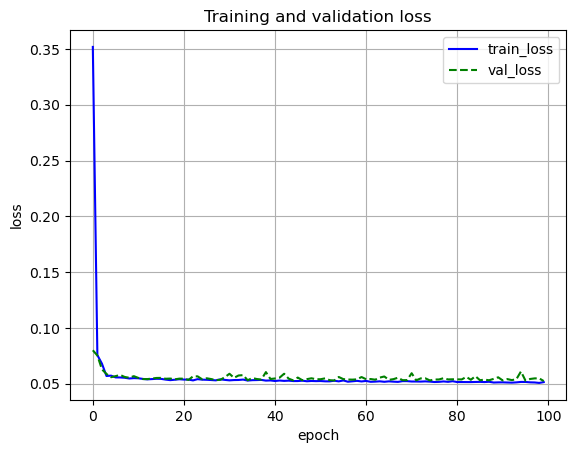

In [37]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

In [38]:
#save model
torch.save(model.state_dict(), '../saved_models/MLP_env1.pth')

In [53]:
#read model
model = MLP(input_size, hidden_size, output_size).to(device)
model.load_state_dict(torch.load('../saved_models/MLP_env1_extract.pth'))
print(model)

MLP(
  (fc1): Linear(in_features=6, out_features=2000, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2000, out_features=2000, bias=True)
  (fc3): Linear(in_features=2000, out_features=56, bias=True)
)


In [54]:
class TestDataset(Dataset):
    def __init__(self, test_data):
        self.test_data = test_data

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, index):
        input = torch.tensor(self.test_data[index], dtype=torch.float32)
        output = 0
        return input, output

初期姿勢：-65°, 終端姿勢：44°
True


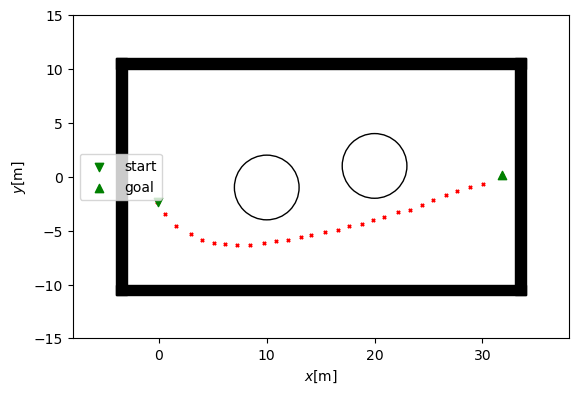

In [57]:
#test_pathの表示
import plot
import random
import utils

#入力のサンプリング
x_start = (random.uniform(-2, 4), random.uniform(-3, 3))  # Starting node
x_goal = (random.uniform(26, 32), random.uniform(-3, 3))  # Goal node

theta_start = random.uniform(-np.pi/2, np.pi/2)
theta_goal = random.uniform(-np.pi/2, np.pi/2)

test_data = np.array([[x_start[0], x_goal[0], x_start[1], x_goal[1], theta_start, theta_goal]])

"""
#正規化する
input_data = np.concatenate([x_data_input, y_data_input, theta_data_input], axis=1)
test_data = (test_data - np.min(input_data, axis=0)) / (np.max(input_data, axis=0) - np.min(input_data, axis=0))
"""

test_data = TestDataset(test_data)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

#予測モード
model.eval()
with torch.no_grad():
    input_data, _ = next(iter(test_loader))
    input_data = input_data.to(device)
    output = model(input_data)
    output = output.view(2, -1)

    
output = output.cpu().numpy()
test_x_path = np.append(output[0], x_goal[0])
test_x_path = np.append(x_start[0], test_x_path)
test_y_path = np.append(output[1], x_goal[1])
test_y_path = np.append(x_start[1], test_y_path)
print("初期姿勢：{}°, 終端姿勢：{}°".format(int(np.degrees(theta_start)), int(np.degrees(theta_goal))))
print(utils.is_collision_free(test_x_path, test_y_path))
plot.vis_path_env1(test_x_path, test_y_path)